In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Recurrent Neural Networks

# Machine Translation
![](https://smerity.com/media/images/articles/2016/gnmt_arch_1_enc_dec.svg)

# Speech Recognition
![](https://cdn-images-1.medium.com/max/1600/1*nJNxFmJaHxyJTtVFkhGTlg.png)

# Image Captioning
![](http://kelvinxu.github.io/projects/diags/model_diag.png)

# Nonsequential Problems

* Object Classification

# Recurrent Neural Network
![](https://cdn-images-1.medium.com/max/1600/0*YNLOjW7YVJarwMD4.png)

# Weight Sharing
* CNNs
    * Share weights across space

* RNNs 
    * Share weights across time

<img src="https://blobscdn.gitbook.com/v0/b/gitbook-28427.appspot.com/o/assets%2F-LIA3amopGH9NC6Rf0mA%2F-LIA3mTJltflw3MVKAEQ%2F-LIA3nSQqdelVePBPCzA%2Fcomputational-graph-2.png?generation=1532415401876532&alt=media">


The same set of weights is used for every time step of the computation.

# Types of Sequence Tasks
![](http://karpathy.github.io/assets/rnn/diags.jpeg)

**One to One:** Object classification with images  

**Many to one:** Text sentiment analysis

**Many to Many:** Translation

<img src="https://blobscdn.gitbook.com/v0/b/gitbook-28427.appspot.com/o/assets%2F-LIA3amopGH9NC6Rf0mA%2F-LIA3mTJltflw3MVKAEQ%2F-LIA3nSSYfP_vAic6Mvf%2Fcomputational-graph-many-to-many.png?generation=1532415395769369&alt=media">


With a **many to many** paradigm the losses are calculated at each timestep/output. Then the loss is backpropagated through the graph to perform gradient descent. With very long time sequences this can lead to vanishing gradients and can become a computational issue. To avoid this **truncated backpropagation through time** (bptt) is sometimes used.

<img src="https://blobscdn.gitbook.com/v0/b/gitbook-28427.appspot.com/o/assets%2F-LIA3amopGH9NC6Rf0mA%2F-LIA3mTJltflw3MVKAEQ%2F-LIA3nSphST_wyjxzKiy%2Ftruncated-backprop.png?generation=1532415397197000&alt=media">


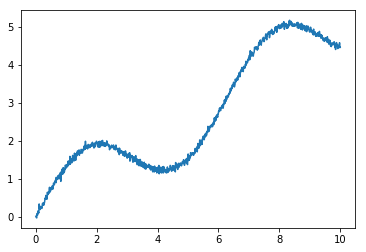

In [2]:
x = np.linspace(0,10,1000); y = np.sin(x) + x/2. + np.random.normal(0,0.05,size=1000)

plt.plot(x,y); plt.show()

# Bad
$y_t = X_{t}\theta + y_{t-1}$

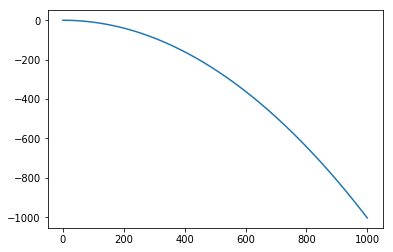

In [3]:
theta = np.random.randn()
val = [0]
for i in x:
    val.append(i * theta + val[-1])
    
plt.plot(val); plt.show()

# Long Short Term Memory (LSTM)
<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" width="750">

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM2-notation.png" width="650">

# Cell State
![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-C-line.png)

# Forget Gate
![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-f.png)

# Input Gate
![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-i.png)

# Cell State Update
![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-C.png)

# Output Gate
![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-o.png)

# Gated Recurrent Unit (GRU)
![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-var-GRU.png)

# LSTMs in Keras

* **units:** Dimension of the output
* **input_shape:** (sequence length, dimension of the input features)
* **return_sequences:** Make predictions at every timestep or only the last one

In [4]:
units = 10
sequence_length = None # variable sequence len
input_feature_dim = 5 
return_sequences = True

In [5]:
model = Sequential()
model.add(LSTM(units, input_shape=(sequence_length, input_feature_dim), return_sequences=return_sequences))
model.add(Dense(13))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 10)          640       
_________________________________________________________________
dense_1 (Dense)              (None, None, 13)          143       
Total params: 783
Trainable params: 783
Non-trainable params: 0
_________________________________________________________________


# Return a Sequence

In [6]:
batch_size = 1
sequence_length = 100

fake_data = np.random.randn(batch_size, sequence_length, input_feature_dim)

In [7]:
model.predict(fake_data).shape

(1, 100, 13)

# Don't Return a Sequence

In [8]:
model = Sequential()
model.add(LSTM(units, input_shape=(sequence_length, input_feature_dim), return_sequences=False))
model.add(Dense(13))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10)                640       
_________________________________________________________________
dense_2 (Dense)              (None, 13)                143       
Total params: 783
Trainable params: 783
Non-trainable params: 0
_________________________________________________________________


In [9]:
batch_size = 1; sequence_length = 100
fake_data = np.random.randn(batch_size, sequence_length, input_feature_dim)

In [10]:
model.predict(fake_data).shape

(1, 13)

In [11]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
# fix random seed for reproducibility
np.random.seed(7)
# load the dataset
dataframe = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv', usecols=[1], engine='python')

dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1

# Load Dataset

In [12]:
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshaping
* Data needs to be of shape (batch, sequence, input feature)

In [13]:
trainX.shape, testX.shape

((94, 1), (46, 1))

# Build the Model

# Training
* Train your model for 100 epochs


# Predictions

In [14]:
# make predictions
trainPredict = # ...
testPredict = # ...

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

SyntaxError: invalid syntax (<ipython-input-14-5d18cfab64b6>, line 2)

# Plotting
* True training data
* Predicted training data, true test data, and 

# References
[Understanding LSTMs](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)